In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FOCAL LOSS FOR IMBALANCED DATA
# ============================================================================
class FocalLoss(nn.Module):
    """Focal Loss: better for imbalanced classification than BCEWithLogitsLoss"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        p = torch.sigmoid(inputs)
        p_t = p * targets + (1 - p) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = self.alpha * focal_weight * bce_loss
        return focal_loss.mean()

# ============================================================================
# CONFIGURATION
# ============================================================================
class Config:
    BERT_MODEL = "bert-base-uncased"
    HIDDEN_SIZE = 768
    GRU_HIDDEN = 64
    GRU_LAYERS = 1
    DROPOUT = 0.6
    
    BATCH_SIZE = 32
    LEARNING_RATE = 3e-5
    EPOCHS = 5
    MAX_LENGTH = 128
    ACCUMULATION_STEPS = 2
    
    NUM_WORKERS = 0
    PIN_MEMORY = True
    PATIENCE = 3
    
    DATA_PATH = "data/dataset.csv"
    SAVE_PATH = "checkpoints2/"

config = Config()

# ============================================================================
# DATASET
# ============================================================================
class AGTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = [str(text).strip()[:512] for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# ============================================================================
# MODEL
# ============================================================================
class BiGRUBertDetector(nn.Module):
    def __init__(self, dropout=0.6):
        super(BiGRUBertDetector, self).__init__()
        
        self.bert = BertModel.from_pretrained(config.BERT_MODEL)
        
        # Freeze early layers
        for param in list(self.bert.parameters())[:200]:
            param.requires_grad = False
        
        self.bigru = nn.GRU(
            input_size=config.HIDDEN_SIZE,
            hidden_size=config.GRU_HIDDEN,
            num_layers=config.GRU_LAYERS,
            bidirectional=True,
            batch_first=True,
        )
        
        self.dropout = nn.Dropout(dropout)
        
        # classifier with batch norm
        self.classifier = nn.Sequential(
            nn.Linear(config.GRU_HIDDEN * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        sequence_output = bert_outputs.last_hidden_state
        
        gru_output, _ = self.bigru(sequence_output)
        
        # Average pooling with attention mask
        mask_expanded = attention_mask.unsqueeze(-1).expand(gru_output.size()).float()
        sum_output = (gru_output * mask_expanded).sum(1)
        sum_mask = mask_expanded.sum(1)
        avg_pooled = sum_output / sum_mask
        
        logits = self.classifier(avg_pooled)
        return logits.squeeze(-1)

# ============================================================================
# TRAINER WITH FOCAL LOSS
# ============================================================================
class Trainer:
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        
        # Use Focal Loss instead of BCEWithLogitsLoss
        self.criterion = FocalLoss(alpha=0.25, gamma=2.0)
        
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=0.01,
            eps=1e-8
        )
        
        self.scheduler = None
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'val_f1': []
        }
        self.best_f1 = 0
        self.patience_counter = 0
    
    def train_epoch(self, train_loader, epoch):
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [TRAIN]")
        
        self.optimizer.zero_grad()
        accumulation_steps = 0
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            labels = batch['label'].to(self.device, non_blocking=True)
            
            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)
            
            loss = loss / config.ACCUMULATION_STEPS
            loss.backward()
            
            accumulation_steps += 1
            
            if accumulation_steps % config.ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.optimizer.zero_grad()
                accumulation_steps = 0
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            preds = (probs > 0.5).astype(float)
            
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())
            
            if len(all_labels) % 200 == 0:
                current_acc = accuracy_score(all_labels, all_preds)
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.4f}'})
        
        avg_loss = total_loss / len(train_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        
        return avg_loss, accuracy
    
    @torch.no_grad()
    def validate(self, val_loader, split_name="Validation"):
        self.model.eval()
        total_loss = 0
        all_probs = []
        all_preds = []
        all_labels = []
        
        for batch in tqdm(val_loader, desc=f"Evaluating {split_name}"):
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            labels = batch['label'].to(self.device, non_blocking=True)
            
            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(float)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
        
        all_probs = np.array(all_probs)
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        avg_loss = total_loss / len(val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0
        
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"\n{'='*80}")
        print(f"{split_name.upper()}")
        print(f"{'='*80}")
        print(f"Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f}")
        print(f"Sensitivity (AI Detection): {sensitivity:.4f} | Specificity: {specificity:.4f}")
        print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        print(f"Prob Distribution: min={all_probs.min():.4f}, max={all_probs.max():.4f}, mean={all_probs.mean():.4f}")
        print(f"Prob Std Dev: {all_probs.std():.4f}")
        print(f"{'='*80}\n")
        
        return avg_loss, accuracy, f1, auc, precision, recall, all_probs, all_labels
    
    def train(self, train_loader, val_loader, test_loader, epochs):
        print(f"\n{'='*80}")
        print(f"TRAINING WITH FOCAL LOSS")
        print(f"{'='*80}")
        print(f"Device: {self.device}")
        print(f"Batch Size: {config.BATCH_SIZE}")
        print(f"Loss: Focal Loss (alpha=0.25, gamma=2.0)")
        print(f"Learning Rate: {config.LEARNING_RATE}")
        print(f"Epochs: {epochs}")
        print(f"{'='*80}\n")
        
        total_steps = len(train_loader) * epochs
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=total_steps
        )
        
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader, epoch)
            val_loss, val_acc, val_f1, val_auc, val_prec, val_rec, _, _ = self.validate(val_loader, "Validation")
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_f1'].append(val_f1)
            
            self.scheduler.step()
            
            if val_f1 > self.best_f1:
                self.best_f1 = val_f1
                self.patience_counter = 0
                self.save_model(f"best_model_f1_{val_f1:.4f}")
                print(f"✅ NEW BEST: F1 = {val_f1:.4f}\n")
            else:
                self.patience_counter += 1
                if self.patience_counter >= config.PATIENCE:
                    print(f"\n⏹️  Early stopping at epoch {epoch+1}\n")
                    break
        
        # Final test evaluation
        print(f"\n{'='*80}")
        print(f"FINAL TEST EVALUATION")
        print(f"{'='*80}")
        test_loss, test_acc, test_f1, test_auc, test_prec, test_rec, test_probs, test_labels = \
            self.validate(test_loader, "TEST")
        
        # Comparison
        print(f"\n{'='*80}")
        print(f"TRAIN vs TEST COMPARISON")
        print(f"{'='*80}")
        print(f"Val F1:  {self.history['val_f1'][-1]:.4f}")
        print(f"Test F1: {test_f1:.4f}")
        print(f"Difference: {abs(test_f1 - self.history['val_f1'][-1]):.4f}")
        
        if test_f1 >= self.history['val_f1'][-1] - 0.05:
            print(f"✅ GOOD: Model generalizes well!")
        else:
            print(f"⚠️  WARNING: Potential overfitting detected")
        print(f"{'='*80}\n")
    
    def save_model(self, filename):
        os.makedirs(config.SAVE_PATH, exist_ok=True)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
        }, f"{config.SAVE_PATH}/{filename}.pth")

# ============================================================================
# DATA LOADING
# ============================================================================
def load_and_prepare_data(file_path):
    print(f"📂 Loading data from {file_path}...")
    
    df = pd.read_csv(file_path)
    texts = df['text'].astype(str).tolist()[:50000]
    labels = df['generated'].astype(int).tolist()[:50000]
    
    print(f"✅ Loaded {len(texts)} samples")
    
    human_count = sum(1 for l in labels if l == 0)
    ai_count = sum(1 for l in labels if l == 1)
    print(f"📊 Distribution - Human: {human_count}, AI: {ai_count}")
    print(f"📊 Ratio: {human_count/ai_count:.2f}:1\n")
    
    return texts, labels

def create_dataloaders(texts, labels, tokenizer):
    """70-15-15 train-val-test split"""
    
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels,
        train_size=0.7,
        stratify=labels,
        random_state=42
    )
    
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels,
        test_size=0.5,
        stratify=temp_labels,
        random_state=42
    )
    
    print(f"{'='*80}")
    print(f"DATA SPLITS")
    print(f"{'='*80}")
    print(f"Train: {len(train_texts)} (H:{train_labels.count(0)}, A:{train_labels.count(1)})")
    print(f"Val:   {len(val_texts)} (H:{val_labels.count(0)}, A:{val_labels.count(1)})")
    print(f"Test:  {len(test_texts)} (H:{test_labels.count(0)}, A:{test_labels.count(1)})")
    print(f"{'='*80}\n")
    
    # Create datasets
    train_dataset = AGTDataset(train_texts, train_labels, tokenizer, config.MAX_LENGTH)
    val_dataset = AGTDataset(val_texts, val_labels, tokenizer, config.MAX_LENGTH)
    test_dataset = AGTDataset(test_texts, test_labels, tokenizer, config.MAX_LENGTH)
    
    # NO weighted sampling - Focal Loss handles imbalance
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY
    )
    
    return train_loader, val_loader, test_loader

# ============================================================================
# MAIN
# ============================================================================
def main():
    if not torch.cuda.is_available():
        print("❌ CUDA not available!")
        return
    
    device = torch.device('cuda')
    print(f"\n✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ CUDA: {torch.version.cuda}")
    print(f"✅ Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB\n")
    
    # Load data
    texts, labels = load_and_prepare_data(config.DATA_PATH)
    
    # Initialize
    tokenizer = BertTokenizer.from_pretrained(config.BERT_MODEL)
    model = BiGRUBertDetector(dropout=config.DROPOUT)
    
    print(f"📊 Model Parameters: {sum(p.numel() for p in model.parameters()):,}\n")
    
    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(texts, labels, tokenizer)
    
    # Train
    trainer = Trainer(model, device=device)
    trainer.train(train_loader, val_loader, test_loader, epochs=config.EPOCHS)

if __name__ == "__main__":
    main()


✅ GPU: NVIDIA GeForce GTX 1660 Ti
✅ CUDA: 12.4
✅ Memory: 6.0 GB

📂 Loading data from data/dataset.csv...
✅ Loaded 50000 samples
📊 Distribution - Human: 17051, AI: 32949
📊 Ratio: 0.52:1

📊 Model Parameters: 109,827,713

DATA SPLITS
Train: 35000 (H:11936, A:23064)
Val:   7500 (H:2557, A:4943)
Test:  7500 (H:2558, A:4942)


TRAINING WITH FOCAL LOSS
Device: cuda
Batch Size: 32
Loss: Focal Loss (alpha=0.25, gamma=2.0)
Learning Rate: 3e-05
Epochs: 10



Evaluating Validation: 100%|██████████| 235/235 [01:29<00:00,  2.64it/s]



VALIDATION
Loss: 0.0138 | Acc: 0.9312 | F1: 0.9493 | AUC: 0.9844
Precision: 0.9236 | Recall: 0.9763
Sensitivity (AI Detection): 0.9763 | Specificity: 0.8440
Confusion Matrix: TP=4826, FP=399, FN=117, TN=2158
Prob Distribution: min=0.1426, max=0.9445, mean=0.6173
Prob Std Dev: 0.1959

✅ NEW BEST: F1 = 0.9493



Evaluating Validation: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s]



VALIDATION
Loss: 0.0108 | Acc: 0.9372 | F1: 0.9540 | AUC: 0.9904
Precision: 0.9224 | Recall: 0.9879
Sensitivity (AI Detection): 0.9879 | Specificity: 0.8393
Confusion Matrix: TP=4883, FP=411, FN=60, TN=2146
Prob Distribution: min=0.1065, max=0.9807, mean=0.6631
Prob Std Dev: 0.2434

✅ NEW BEST: F1 = 0.9540



Evaluating Validation: 100%|██████████| 235/235 [01:20<00:00,  2.92it/s]



VALIDATION
Loss: 0.0078 | Acc: 0.9597 | F1: 0.9700 | AUC: 0.9938
Precision: 0.9538 | Recall: 0.9866
Sensitivity (AI Detection): 0.9866 | Specificity: 0.9077
Confusion Matrix: TP=4877, FP=236, FN=66, TN=2321
Prob Distribution: min=0.0606, max=0.9892, mean=0.6531
Prob Std Dev: 0.2803

✅ NEW BEST: F1 = 0.9700



Evaluating Validation: 100%|██████████| 235/235 [01:20<00:00,  2.92it/s]



VALIDATION
Loss: 0.0072 | Acc: 0.9605 | F1: 0.9707 | AUC: 0.9955
Precision: 0.9518 | Recall: 0.9903
Sensitivity (AI Detection): 0.9903 | Specificity: 0.9030
Confusion Matrix: TP=4895, FP=248, FN=48, TN=2309
Prob Distribution: min=0.0568, max=0.9918, mean=0.6723
Prob Std Dev: 0.2924

✅ NEW BEST: F1 = 0.9707



Evaluating Validation: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s]



VALIDATION
Loss: 0.0077 | Acc: 0.9553 | F1: 0.9670 | AUC: 0.9968
Precision: 0.9417 | Recall: 0.9937
Sensitivity (AI Detection): 0.9937 | Specificity: 0.8811
Confusion Matrix: TP=4912, FP=304, FN=31, TN=2253
Prob Distribution: min=0.0563, max=0.9943, mean=0.6978
Prob Std Dev: 0.3002



Evaluating Validation: 100%|██████████| 235/235 [01:21<00:00,  2.90it/s]



VALIDATION
Loss: 0.0057 | Acc: 0.9669 | F1: 0.9754 | AUC: 0.9976
Precision: 0.9582 | Recall: 0.9931
Sensitivity (AI Detection): 0.9931 | Specificity: 0.9163
Confusion Matrix: TP=4909, FP=214, FN=34, TN=2343
Prob Distribution: min=0.0378, max=0.9955, mean=0.6847
Prob Std Dev: 0.3208

✅ NEW BEST: F1 = 0.9754



Evaluating Validation: 100%|██████████| 235/235 [01:29<00:00,  2.63it/s]



VALIDATION
Loss: 0.0057 | Acc: 0.9675 | F1: 0.9758 | AUC: 0.9981
Precision: 0.9572 | Recall: 0.9951
Sensitivity (AI Detection): 0.9951 | Specificity: 0.9140
Confusion Matrix: TP=4919, FP=220, FN=24, TN=2337
Prob Distribution: min=0.0346, max=0.9968, mean=0.6960
Prob Std Dev: 0.3308

✅ NEW BEST: F1 = 0.9758



Evaluating Validation: 100%|██████████| 235/235 [01:24<00:00,  2.79it/s]



VALIDATION
Loss: 0.0053 | Acc: 0.9692 | F1: 0.9771 | AUC: 0.9984
Precision: 0.9596 | Recall: 0.9951
Sensitivity (AI Detection): 0.9951 | Specificity: 0.9190
Confusion Matrix: TP=4919, FP=207, FN=24, TN=2350
Prob Distribution: min=0.0317, max=0.9973, mean=0.6978
Prob Std Dev: 0.3400

✅ NEW BEST: F1 = 0.9771



Evaluating Validation: 100%|██████████| 235/235 [01:22<00:00,  2.86it/s]



VALIDATION
Loss: 0.0042 | Acc: 0.9763 | F1: 0.9822 | AUC: 0.9986
Precision: 0.9696 | Recall: 0.9951
Sensitivity (AI Detection): 0.9951 | Specificity: 0.9398
Confusion Matrix: TP=4919, FP=154, FN=24, TN=2403
Prob Distribution: min=0.0249, max=0.9969, mean=0.6857
Prob Std Dev: 0.3518

✅ NEW BEST: F1 = 0.9822



Evaluating Validation: 100%|██████████| 235/235 [01:21<00:00,  2.89it/s]



VALIDATION
Loss: 0.0040 | Acc: 0.9767 | F1: 0.9825 | AUC: 0.9988
Precision: 0.9702 | Recall: 0.9951
Sensitivity (AI Detection): 0.9951 | Specificity: 0.9409
Confusion Matrix: TP=4919, FP=151, FN=24, TN=2406
Prob Distribution: min=0.0217, max=0.9972, mean=0.6881
Prob Std Dev: 0.3593

✅ NEW BEST: F1 = 0.9825


FINAL TEST EVALUATION


Evaluating TEST: 100%|██████████| 235/235 [01:22<00:00,  2.86it/s]



TEST
Loss: 0.0048 | Acc: 0.9745 | F1: 0.9810 | AUC: 0.9983
Precision: 0.9670 | Recall: 0.9953
Sensitivity (AI Detection): 0.9953 | Specificity: 0.9343
Confusion Matrix: TP=4919, FP=168, FN=23, TN=2390
Prob Distribution: min=0.0252, max=0.9977, mean=0.6895
Prob Std Dev: 0.3571


TRAIN vs TEST COMPARISON
Val F1:  0.9825
Test F1: 0.9810
Difference: 0.0016
✅ GOOD: Model generalizes well!



Charts

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import pandas as pd
from tqdm import tqdm
import os

# Load your existing configuration
class Config:
    BERT_MODEL = "bert-base-uncased"
    HIDDEN_SIZE = 768
    GRU_HIDDEN = 64
    GRU_LAYERS = 1
    DROPOUT = 0.6
    BATCH_SIZE = 32
    MAX_LENGTH = 128
    DATA_PATH = "data/dataset.csv"
    SAVE_PATH = "checkpoints2/"

config = Config()

from transformers import BertTokenizer, BertModel
import torch.nn as nn

class ImprovedBiGRUBertDetector(nn.Module):
    def __init__(self, dropout=0.6):
        super(ImprovedBiGRUBertDetector, self).__init__()
        self.bert = BertModel.from_pretrained(config.BERT_MODEL)
        for param in list(self.bert.parameters())[:200]:
            param.requires_grad = False
        self.bigru = nn.GRU(
            input_size=config.HIDDEN_SIZE,
            hidden_size=config.GRU_HIDDEN,
            num_layers=config.GRU_LAYERS,
            bidirectional=True,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(config.GRU_HIDDEN * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        sequence_output = bert_outputs.last_hidden_state
        gru_output, _ = self.bigru(sequence_output)
        mask_expanded = attention_mask.unsqueeze(-1).expand(gru_output.size()).float()
        sum_output = (gru_output * mask_expanded).sum(1)
        sum_mask = mask_expanded.sum(1)
        avg_pooled = sum_output / sum_mask
        logits = self.classifier(avg_pooled)
        return logits.squeeze(-1)

# Dataset class
class ImprovedAGTDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = [str(text).strip()[:512] for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

def load_model_and_predict():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load tokenizer and model
    tokenizer = BertTokenizer.from_pretrained(config.BERT_MODEL)
    model = ImprovedBiGRUBertDetector(dropout=config.DROPOUT)
    
    # Find the best model checkpoint
    checkpoint_files = os.listdir(config.SAVE_PATH)
    best_checkpoint = None
    for file in checkpoint_files:
        if file.startswith("best_model_f1_") and file.endswith(".pth"):
            best_checkpoint = file
            break
    
    if best_checkpoint is None:
        print("No best model found, using any checkpoint")
        best_checkpoint = checkpoint_files[0]
    
    print(f"Loading model: {best_checkpoint}")
    checkpoint = torch.load(f"{config.SAVE_PATH}/{best_checkpoint}", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Load data
    print("Loading data...")
    df = pd.read_csv(config.DATA_PATH)
    texts = df['text'].astype(str).tolist()[:50000]
    labels = df['generated'].astype(int).tolist()[:50000]
    
    # Recreate the same split (important!)
    from sklearn.model_selection import train_test_split
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, train_size=0.7, stratify=labels, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    
    # Create test dataset
    test_dataset = ImprovedAGTDataset(test_texts, test_labels, tokenizer, config.MAX_LENGTH)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config.BATCH_SIZE, shuffle=False
    )
    
    # Run predictions
    print("Running predictions...")
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(float)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_probs), np.array(all_preds), np.array(all_labels), test_texts

def create_all_visualizations(probs, preds, labels, texts):
    """Create comprehensive visualizations for your project"""
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. CONFUSION MATRIX
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Human', 'AI'], 
                yticklabels=['Human', 'AI'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 2. ROC CURVE
    plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)
    plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # 3. PRECISION-RECALL CURVE
    plt.subplot(2, 3, 3)
    precision, recall, _ = precision_recall_curve(labels, probs)
    avg_precision = average_precision_score(labels, probs)
    plt.plot(recall, precision, linewidth=2, label=f'AP = {avg_precision:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    
    # 4. PROBABILITY DISTRIBUTION
    plt.subplot(2, 3, 4)
    human_probs = probs[labels == 0]
    ai_probs = probs[labels == 1]
    
    plt.hist(human_probs, bins=50, alpha=0.7, label='Human', density=True)
    plt.hist(ai_probs, bins=50, alpha=0.7, label='AI', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Probability Distribution by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. PERFORMANCE METRICS BAR CHART
    plt.subplot(2, 3, 5)
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]
    
    bars = plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.4f}', ha='center', va='bottom')
    
    # 6. CLASS DISTRIBUTION
    plt.subplot(2, 3, 6)
    class_counts = [np.sum(labels == 0), np.sum(labels == 1)]
    plt.pie(class_counts, labels=['Human', 'AI'], autopct='%1.1f%%', 
            colors=['lightblue', 'lightcoral'])
    plt.title('Test Set Class Distribution')
    
    plt.tight_layout()
    plt.savefig('model_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. TRAINING HISTORY (if available in checkpoint)
    try:
        plt.figure(figsize=(12, 4))
        
        # Check if history exists in checkpoint
        if 'history' in checkpoint:
            history = checkpoint['history']
            
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training & Validation Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.plot(history['train_acc'], label='Train Acc')
            plt.plot(history['val_acc'], label='Val Acc')
            plt.plot(history['val_f1'], label='Val F1', linestyle='--')
            plt.xlabel('Epoch')
            plt.ylabel('Score')
            plt.title('Training & Validation Metrics')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
            plt.show()
    except:
        print("Training history not available in checkpoint")

def create_detailed_analysis(probs, labels, texts):
    """Create additional detailed analysis"""
    
    # Error analysis - find misclassified examples
    preds = (probs > 0.5).astype(float)
    incorrect_indices = np.where(preds != labels)[0]
    
    print(f"\n{'='*60}")
    print("ERROR ANALYSIS")
    print(f"{'='*60}")
    print(f"Total misclassified: {len(incorrect_indices)}/{len(labels)} ({len(incorrect_indices)/len(labels)*100:.2f}%)")
    
    # Show some misclassified examples
    print(f"\nSample misclassified examples:")
    for i in incorrect_indices[:5]:  # Show first 5 errors
        actual = "Human" if labels[i] == 0 else "AI"
        predicted = "Human" if preds[i] == 0 else "AI"
        confidence = probs[i] if preds[i] == 1 else 1 - probs[i]
        print(f"Text: {texts[i][:100]}...")
        print(f"Actual: {actual}, Predicted: {predicted}, Confidence: {confidence:.4f}")
        print("-" * 50)
    
    # Confidence analysis
    plt.figure(figsize=(10, 6))
    
    correct_probs = probs[preds == labels]
    incorrect_probs = probs[preds != labels]
    
    plt.hist(correct_probs, bins=30, alpha=0.7, label='Correct', density=True)
    plt.hist(incorrect_probs, bins=30, alpha=0.7, label='Incorrect', density=True)
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Density')
    plt.title('Prediction Confidence: Correct vs Incorrect')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    from sklearn.metrics import roc_auc_score, average_precision_score
    
    print("Loading model and generating predictions...")
    probs, preds, labels, texts = load_model_and_predict()
    
    print("Creating visualizations...")
    create_all_visualizations(probs, preds, labels, texts)
    
    print("Creating detailed analysis...")
    create_detailed_analysis(probs, labels, texts)
    
    print("✅ All visualizations saved as PNG files!")

Comparative visuals of with and without adversarial training


ADVANCED COMPARISON VISUALIZATIONS
Baseline vs Adversarial-Trained Models

✅ Using device: cuda

📥 Loading BASELINE model...


C:\Users\nidhi\AppData\Local\Temp\ipykernel_22040\2566407609.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f"{config.CHECKPOINT_WITHOUT}/{best_file

✓ Loaded

📥 Loading ADVERSARIAL model...


C:\Users\nidhi\AppData\Local\Temp\ipykernel_22040\2566407609.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f"{config.CHECKPOINT_WITH}/{best_file}",

✓ Loaded

📂 Loading test data...
✓ Test set: 73086 samples

🔮 Generating predictions for BASELINE model...


🔮 Generating predictions for ADVERSARIAL model...



📊 Calculating metrics...

🎨 Creating visualizations...

✅ Saved: 01_confusion_matrices_comparison.png


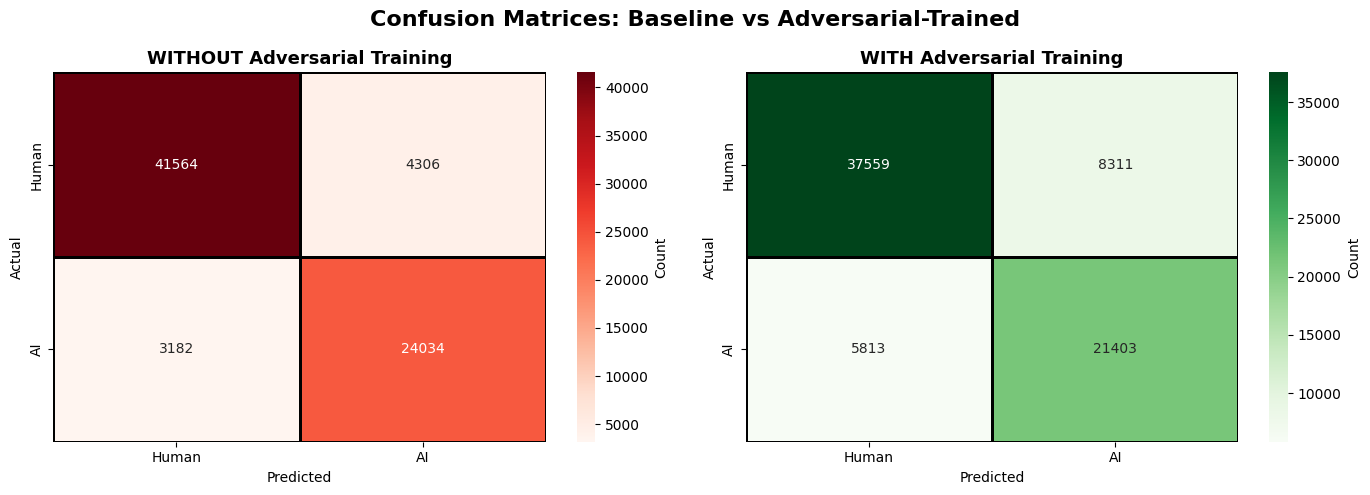

✅ Saved: 02_roc_pr_curves_comparison.png


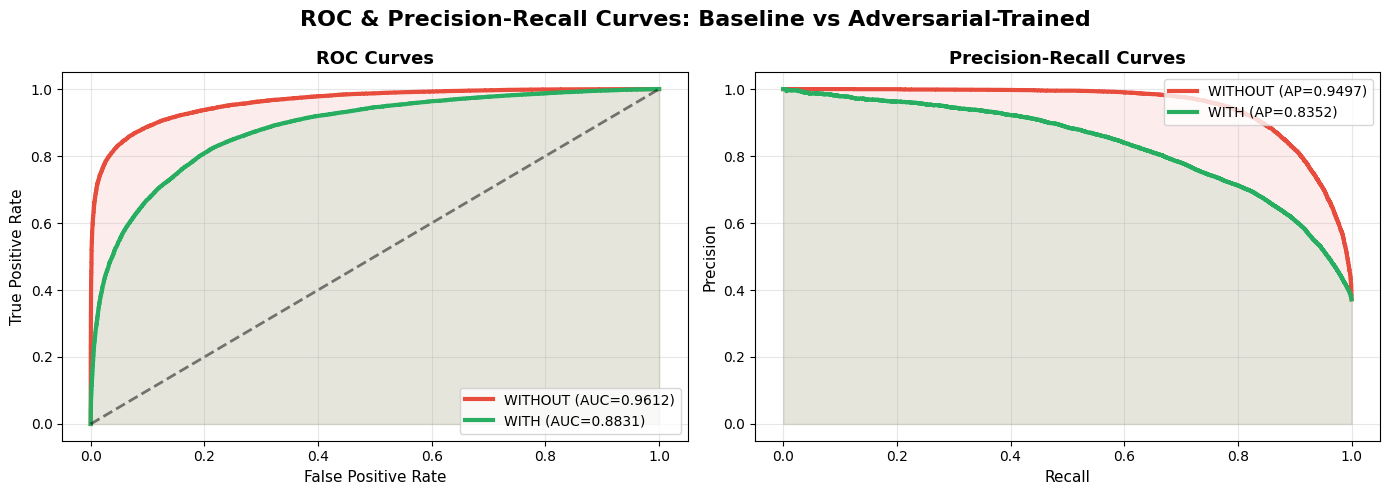

✅ Saved: 04_metrics_comparison.png


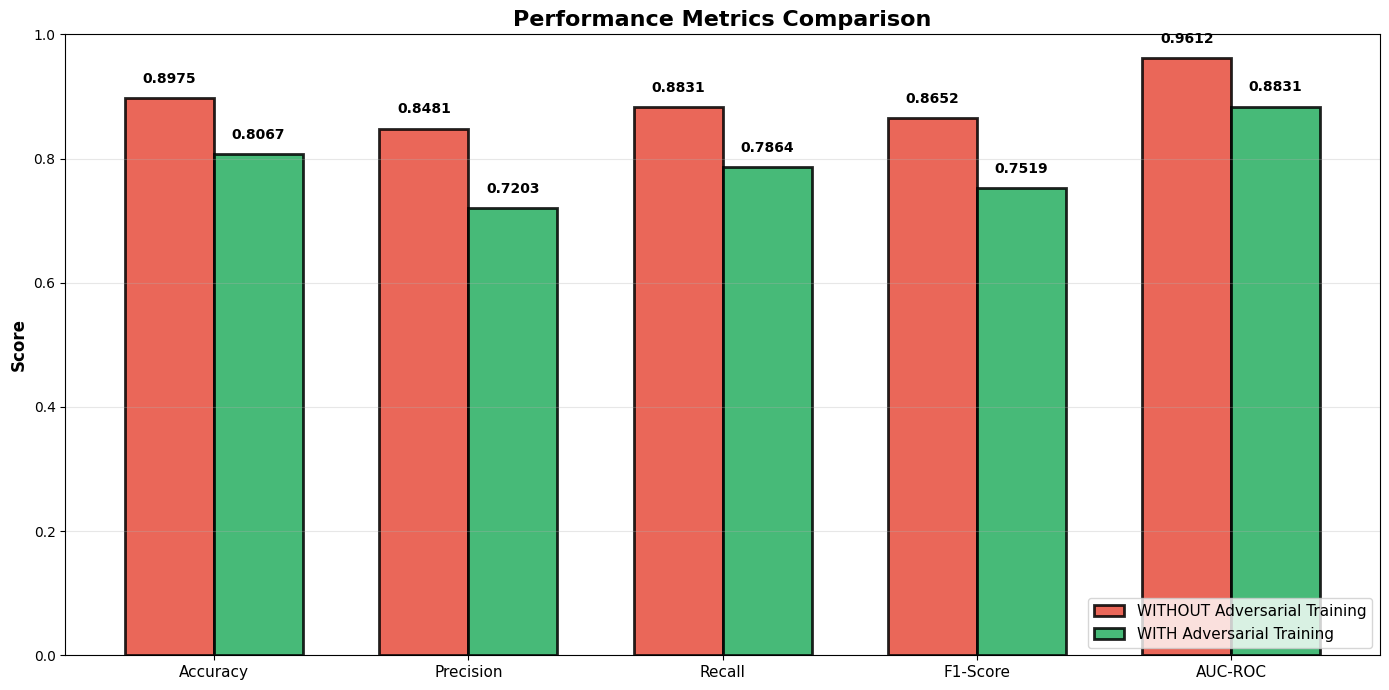

✅ Saved: 05_error_analysis_comparison.png


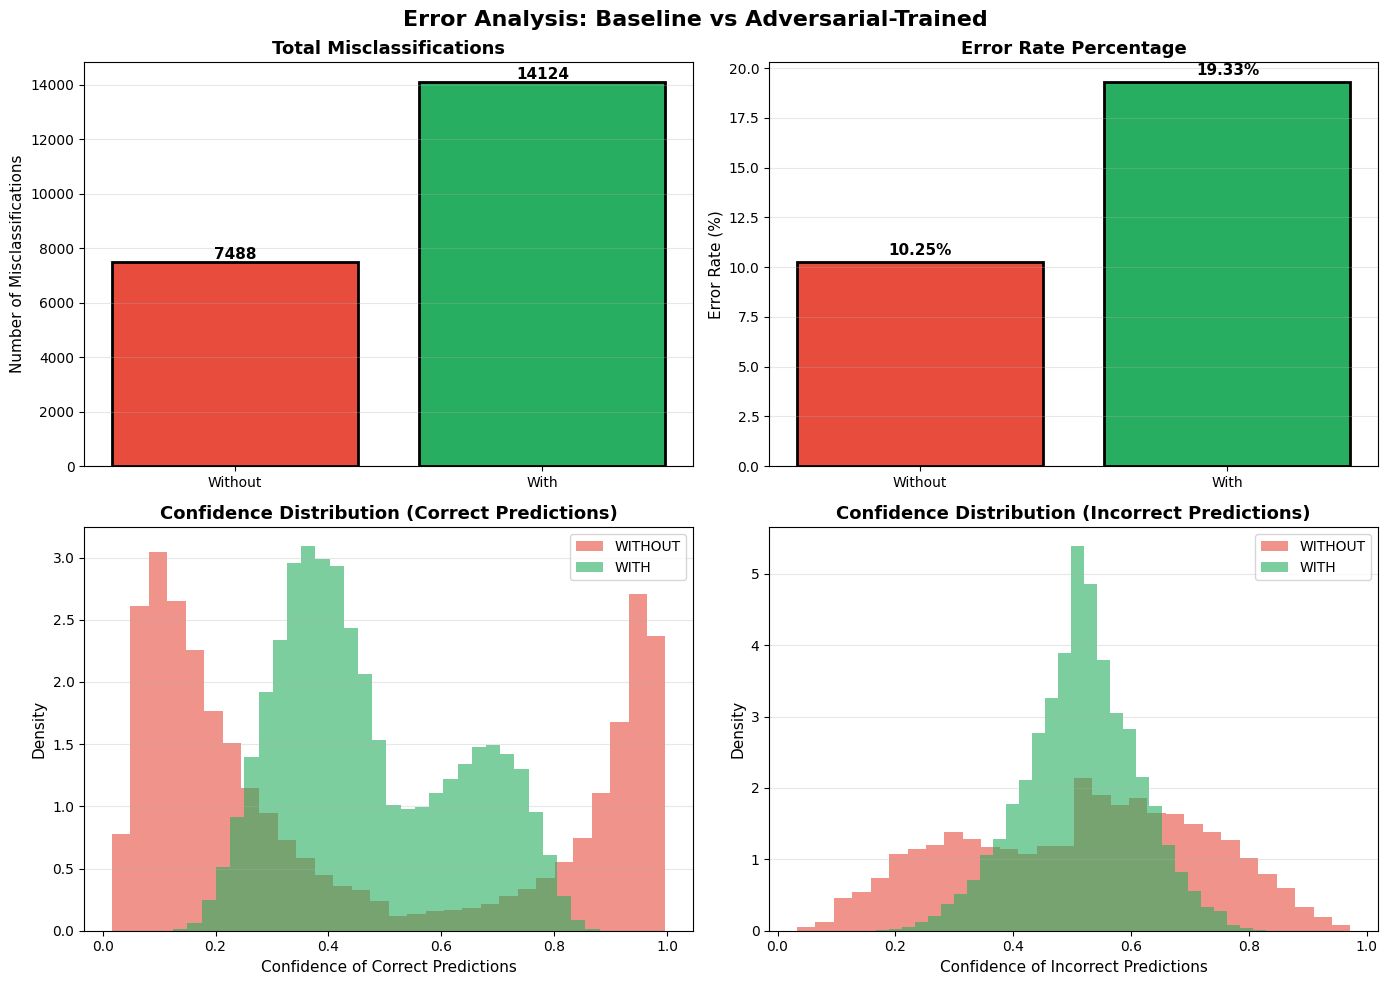

✅ Saved: 06_improvement_summary.png


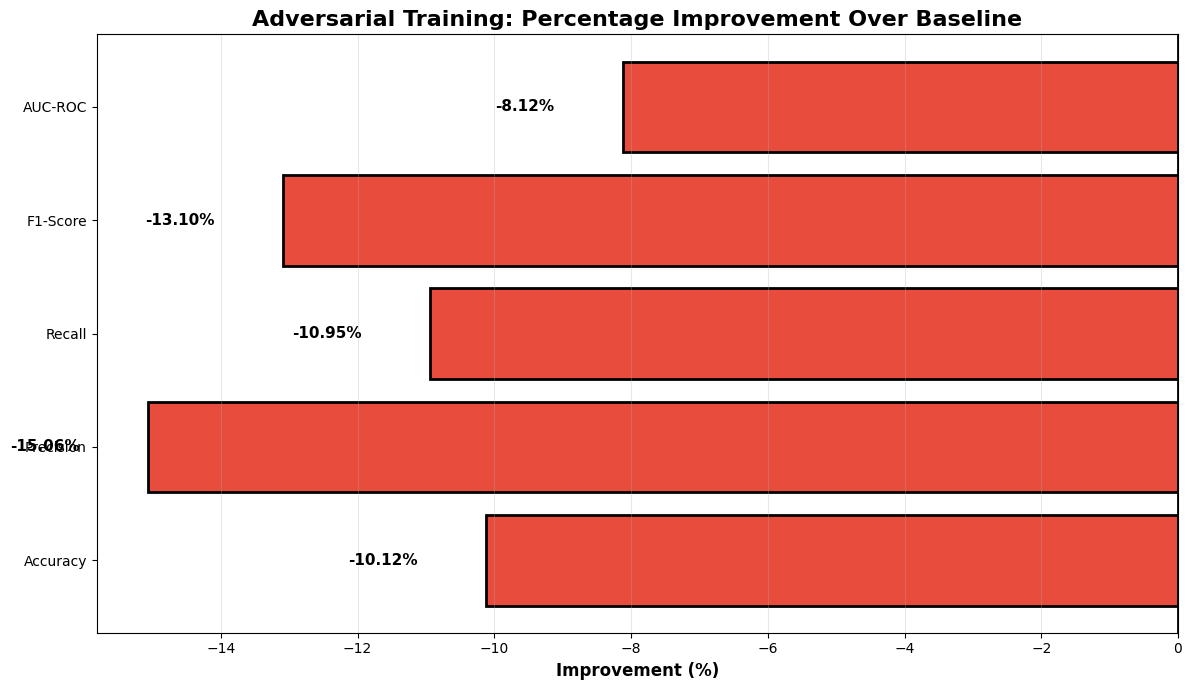


SUMMARY STATISTICS

BASELINE MODEL (WITHOUT Adversarial Training)
  Accuracy:  0.8975
  Precision: 0.8481
  Recall:    0.8831
  F1-Score:  0.8652
  AUC-ROC:   0.9612

ADVERSARIAL MODEL (WITH Adversarial Training)
  Accuracy:  0.8067
  Precision: 0.7203
  Recall:    0.7864
  F1-Score:  0.7519
  AUC-ROC:   0.8831

✅ ALL VISUALIZATIONS COMPLETE!

📁 Generated files:
   - 01_confusion_matrices_comparison.png
   - 02_roc_pr_curves_comparison.png
   - 04_metrics_comparison.png
   - 05_error_analysis_comparison.png
   - 06_improvement_summary.png



In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, precision_recall_curve,
                           roc_auc_score, average_precision_score, accuracy_score,
                           precision_score, recall_score, f1_score)
import pandas as pd
from tqdm import tqdm
import os

# ============================================================================
# CONFIGURATION
# ============================================================================
class Config:
    BERT_MODEL = "bert-base-uncased"
    HIDDEN_SIZE = 768
    GRU_HIDDEN = 64
    GRU_LAYERS = 1
    DROPOUT = 0.6
    BATCH_SIZE = 32
    MAX_LENGTH = 128
    DATA_PATH = "data/dataset.csv"
    CHECKPOINT_WITHOUT = "checkpoints2/"
    CHECKPOINT_WITH = "checkpoints_t5_adversarial/"

config = Config()

from transformers import BertTokenizer, BertModel
import torch.nn as nn

class ImprovedBiGRUBertDetector(nn.Module):
    def __init__(self, dropout=0.6):
        super(ImprovedBiGRUBertDetector, self).__init__()
        self.bert = BertModel.from_pretrained(config.BERT_MODEL)
        for param in list(self.bert.parameters())[:200]:
            param.requires_grad = False
        self.bigru = nn.GRU(
            input_size=config.HIDDEN_SIZE,
            hidden_size=config.GRU_HIDDEN,
            num_layers=config.GRU_LAYERS,
            bidirectional=True,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(config.GRU_HIDDEN * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        sequence_output = bert_outputs.last_hidden_state
        gru_output, _ = self.bigru(sequence_output)
        mask_expanded = attention_mask.unsqueeze(-1).expand(gru_output.size()).float()
        sum_output = (gru_output * mask_expanded).sum(1)
        sum_mask = mask_expanded.sum(1)
        avg_pooled = sum_output / sum_mask
        logits = self.classifier(avg_pooled)
        return logits.squeeze(-1)

class ImprovedAGTDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = [str(text).strip()[:512] for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, max_length=self.max_length, 
                                 padding='max_length', truncation=True, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# ============================================================================
# LOAD BOTH MODELS
# ============================================================================
def load_both_models():
    """Load baseline and adversarial models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ Using device: {device}\n")
    
    tokenizer = BertTokenizer.from_pretrained(config.BERT_MODEL)
    
    # Load baseline
    print("📥 Loading BASELINE model...")
    model_without = ImprovedBiGRUBertDetector(dropout=config.DROPOUT)
    checkpoint_files = [f for f in os.listdir(config.CHECKPOINT_WITHOUT) if f.startswith("best_")]
    if checkpoint_files:
        best_file = sorted(checkpoint_files)[-1]
        ckpt = torch.load(f"{config.CHECKPOINT_WITHOUT}/{best_file}", map_location=device)
        model_without.load_state_dict(ckpt['model_state_dict'])
    model_without.to(device)
    model_without.eval()
    print(f"✓ Loaded\n")
    
    # Load adversarial
    print("📥 Loading ADVERSARIAL model...")
    model_with = ImprovedBiGRUBertDetector(dropout=config.DROPOUT)
    checkpoint_files = [f for f in os.listdir(config.CHECKPOINT_WITH) if f.startswith("best_")]
    if checkpoint_files:
        best_file = sorted(checkpoint_files)[-1]
        ckpt = torch.load(f"{config.CHECKPOINT_WITH}/{best_file}", map_location=device)
        model_with.load_state_dict(ckpt['model_state_dict'])
    model_with.to(device)
    model_with.eval()
    print(f"✓ Loaded\n")
    
    # Load data
    print("📂 Loading test data...")
    df = pd.read_csv(config.DATA_PATH)
    texts = df['text'].astype(str).tolist()
    labels = df['generated'].astype(int).tolist()
    
    from sklearn.model_selection import train_test_split
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, train_size=0.7, stratify=labels, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    
    print(f"✓ Test set: {len(test_texts)} samples\n")
    return model_without, model_with, tokenizer, test_texts, test_labels, device

# ============================================================================
# GET PREDICTIONS
# ============================================================================
def get_predictions(model, texts, labels, tokenizer, device):
    """Generate predictions"""
    dataset = ImprovedAGTDataset(texts, labels, tokenizer, config.MAX_LENGTH)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    
    all_probs = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
    
    return np.array(all_probs)

# ============================================================================
# GENERATE COMPARISON METRICS
# ============================================================================
def get_metrics(probs, labels):
    """Calculate all metrics"""
    preds = (probs > 0.5).astype(float)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds),
        'auc': roc_auc_score(labels, probs),
        'probs': probs,
        'preds': preds
    }

# ============================================================================
# FIGURE 1: SIDE-BY-SIDE CONFUSION MATRICES
# ============================================================================
def plot_confusion_matrices(probs_without, labels, probs_with):
    """Side-by-side confusion matrices"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Confusion Matrices: Baseline vs Adversarial-Trained',
                fontsize=16, fontweight='bold')
    
    preds_without = (probs_without > 0.5).astype(float)
    preds_with = (probs_with > 0.5).astype(float)
    
    cm_without = confusion_matrix(labels, preds_without)
    cm_with = confusion_matrix(labels, preds_with)
    
    sns.heatmap(cm_without, annot=True, fmt='d', cmap='Reds', ax=axes[0],
               xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'],
               cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
    axes[0].set_title('WITHOUT Adversarial Training', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    sns.heatmap(cm_with, annot=True, fmt='d', cmap='Greens', ax=axes[1],
               xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'],
               cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
    axes[1].set_title('WITH Adversarial Training', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('01_confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: 01_confusion_matrices_comparison.png")
    plt.show()

# ============================================================================
# FIGURE 2: SIDE-BY-SIDE ROC & PR CURVES
# ============================================================================
def plot_roc_pr_curves(probs_without, labels, probs_with):
    """Side-by-side ROC and PR curves"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('ROC & Precision-Recall Curves: Baseline vs Adversarial-Trained',
                fontsize=16, fontweight='bold')
    
    # ROC Curves
    fpr_without, tpr_without, _ = roc_curve(labels, probs_without)
    fpr_with, tpr_with, _ = roc_curve(labels, probs_with)
    auc_without = roc_auc_score(labels, probs_without)
    auc_with = roc_auc_score(labels, probs_with)
    
    axes[0].plot(fpr_without, tpr_without, linewidth=3, 
                label=f'WITHOUT (AUC={auc_without:.4f})', color='#E74C3C')
    axes[0].plot(fpr_with, tpr_with, linewidth=3,
                label=f'WITH (AUC={auc_with:.4f})', color='#27AE60')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    axes[0].fill_between(fpr_without, tpr_without, alpha=0.1, color='#E74C3C')
    axes[0].fill_between(fpr_with, tpr_with, alpha=0.1, color='#27AE60')
    axes[0].set_xlabel('False Positive Rate', fontsize=11)
    axes[0].set_ylabel('True Positive Rate', fontsize=11)
    axes[0].set_title('ROC Curves', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10, loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # PR Curves
    prec_without, rec_without, _ = precision_recall_curve(labels, probs_without)
    prec_with, rec_with, _ = precision_recall_curve(labels, probs_with)
    ap_without = average_precision_score(labels, probs_without)
    ap_with = average_precision_score(labels, probs_with)
    
    axes[1].plot(rec_without, prec_without, linewidth=3,
                label=f'WITHOUT (AP={ap_without:.4f})', color='#E74C3C')
    axes[1].plot(rec_with, prec_with, linewidth=3,
                label=f'WITH (AP={ap_with:.4f})', color='#27AE60')
    axes[1].fill_between(rec_without, prec_without, alpha=0.1, color='#E74C3C')
    axes[1].fill_between(rec_with, prec_with, alpha=0.1, color='#27AE60')
    axes[1].set_xlabel('Recall', fontsize=11)
    axes[1].set_ylabel('Precision', fontsize=11)
    axes[1].set_title('Precision-Recall Curves', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10, loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('02_roc_pr_curves_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: 02_roc_pr_curves_comparison.png")
    plt.show()

# ============================================================================
# FIGURE 4: METRICS BAR COMPARISON
# ============================================================================
def plot_metrics_comparison(metrics_without, metrics_with):
    """Compare all metrics side-by-side"""
    fig, ax = plt.subplots(figsize=(14, 7))
    
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    without_vals = [metrics_without['accuracy'], metrics_without['precision'],
                   metrics_without['recall'], metrics_without['f1'], metrics_without['auc']]
    with_vals = [metrics_with['accuracy'], metrics_with['precision'],
                metrics_with['recall'], metrics_with['f1'], metrics_with['auc']]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, without_vals, width, label='WITHOUT Adversarial Training',
                  color='#E74C3C', edgecolor='black', linewidth=2, alpha=0.85)
    bars2 = ax.bar(x + width/2, with_vals, width, label='WITH Adversarial Training',
                  color='#27AE60', edgecolor='black', linewidth=2, alpha=0.85)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, fontsize=11)
    ax.set_ylim(0, 1)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('04_metrics_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: 04_metrics_comparison.png")
    plt.show()

# ============================================================================
# FIGURE 5: ERROR ANALYSIS COMPARISON
# ============================================================================
def plot_error_analysis(probs_without, labels, probs_with):
    """Compare error rates and misclassifications"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Error Analysis: Baseline vs Adversarial-Trained',
                fontsize=16, fontweight='bold')
    
    preds_without = (probs_without > 0.5).astype(float)
    preds_with = (probs_with > 0.5).astype(float)
    
    # Total misclassifications
    errors_without = np.sum(preds_without != labels)
    errors_with = np.sum(preds_with != labels)
    
    ax = axes[0, 0]
    error_types = ['Without', 'With']
    error_counts = [errors_without, errors_with]
    colors = ['#E74C3C', '#27AE60']
    bars = ax.bar(error_types, error_counts, color=colors, edgecolor='black', linewidth=2)
    ax.set_ylabel('Number of Misclassifications', fontsize=11)
    ax.set_title('Total Misclassifications', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar, count in zip(bars, error_counts):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
               f'{int(count)}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Error percentage
    ax = axes[0, 1]
    error_pct_without = (errors_without / len(labels)) * 100
    error_pct_with = (errors_with / len(labels)) * 100
    error_pcts = [error_pct_without, error_pct_with]
    bars = ax.bar(error_types, error_pcts, color=colors, edgecolor='black', linewidth=2)
    ax.set_ylabel('Error Rate (%)', fontsize=11)
    ax.set_title('Error Rate Percentage', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar, pct in zip(bars, error_pcts):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
               f'{pct:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Confidence of correct predictions
    ax = axes[1, 0]
    correct_without = probs_without[preds_without == labels]
    correct_with = probs_with[preds_with == labels]
    
    ax.hist(correct_without, bins=30, alpha=0.6, label='WITHOUT', color='#E74C3C', density=True)
    ax.hist(correct_with, bins=30, alpha=0.6, label='WITH', color='#27AE60', density=True)
    ax.set_xlabel('Confidence of Correct Predictions', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title('Confidence Distribution (Correct Predictions)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Confidence of incorrect predictions
    ax = axes[1, 1]
    incorrect_without = probs_without[preds_without != labels]
    incorrect_with = probs_with[preds_with != labels]
    
    ax.hist(incorrect_without, bins=30, alpha=0.6, label='WITHOUT', color='#E74C3C', density=True)
    ax.hist(incorrect_with, bins=30, alpha=0.6, label='WITH', color='#27AE60', density=True)
    ax.set_xlabel('Confidence of Incorrect Predictions', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title('Confidence Distribution (Incorrect Predictions)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('05_error_analysis_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: 05_error_analysis_comparison.png")
    plt.show()

# ============================================================================
# FIGURE 6: IMPROVEMENT SUMMARY
# ============================================================================
def plot_improvement_summary(metrics_without, metrics_with):
    """Show improvements as percentage gains"""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    improvements = [
        ((metrics_with['accuracy'] - metrics_without['accuracy']) / metrics_without['accuracy'] * 100),
        ((metrics_with['precision'] - metrics_without['precision']) / metrics_without['precision'] * 100),
        ((metrics_with['recall'] - metrics_without['recall']) / metrics_without['recall'] * 100),
        ((metrics_with['f1'] - metrics_without['f1']) / metrics_without['f1'] * 100),
        ((metrics_with['auc'] - metrics_without['auc']) / metrics_without['auc'] * 100),
    ]
    
    colors = ['#27AE60' if imp > 0 else '#E74C3C' for imp in improvements]
    
    bars = ax.barh(metrics_names, improvements, color=colors, edgecolor='black', linewidth=2)
    ax.axvline(0, color='black', linestyle='-', linewidth=2)
    ax.set_xlabel('Improvement (%)', fontsize=12, fontweight='bold')
    ax.set_title('Adversarial Training: Percentage Improvement Over Baseline',
                fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    for bar, imp in zip(bars, improvements):
        width = bar.get_width()
        label_x = width + (1 if width > 0 else -1)
        ax.text(label_x, bar.get_y() + bar.get_height()/2.,
               f'{imp:+.2f}%', ha='left' if width > 0 else 'right', 
               va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('06_improvement_summary.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: 06_improvement_summary.png")
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    print("\n" + "="*80)
    print("ADVANCED COMPARISON VISUALIZATIONS")
    print("Baseline vs Adversarial-Trained Models")
    print("="*80 + "\n")
    
    # Load models
    model_without, model_with, tokenizer, test_texts, test_labels, device = load_both_models()
    
    # Get predictions
    print("🔮 Generating predictions for BASELINE model...")
    probs_without = get_predictions(model_without, test_texts, test_labels, tokenizer, device)
    
    print("🔮 Generating predictions for ADVERSARIAL model...")
    probs_with = get_predictions(model_with, test_texts, test_labels, tokenizer, device)
    
    # Calculate metrics
    print("\n📊 Calculating metrics...\n")
    metrics_without = get_metrics(probs_without, test_labels)
    metrics_with = get_metrics(probs_with, test_labels)
    
    # Create all visualizations
    print("🎨 Creating visualizations...\n")
    plot_confusion_matrices(probs_without, test_labels, probs_with)
    plot_roc_pr_curves(probs_without, test_labels, probs_with)
    plot_metrics_comparison(metrics_without, metrics_with)
    plot_error_analysis(probs_without, test_labels, probs_with)
    plot_improvement_summary(metrics_without, metrics_with)
    
    # Print summary
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80 + "\n")
    
    print("BASELINE MODEL (WITHOUT Adversarial Training)")
    print(f"  Accuracy:  {metrics_without['accuracy']:.4f}")
    print(f"  Precision: {metrics_without['precision']:.4f}")
    print(f"  Recall:    {metrics_without['recall']:.4f}")
    print(f"  F1-Score:  {metrics_without['f1']:.4f}")
    print(f"  AUC-ROC:   {metrics_without['auc']:.4f}\n")
    
    print("ADVERSARIAL MODEL (WITH Adversarial Training)")
    print(f"  Accuracy:  {metrics_with['accuracy']:.4f}")
    print(f"  Precision: {metrics_with['precision']:.4f}")
    print(f"  Recall:    {metrics_with['recall']:.4f}")
    print(f"  F1-Score:  {metrics_with['f1']:.4f}")
    print(f"  AUC-ROC:   {metrics_with['auc']:.4f}\n")
    
    print("="*80)
    print("✅ ALL VISUALIZATIONS COMPLETE!")
    print("="*80)
    print("\n📁 Generated files:")
    print("   - 01_confusion_matrices_comparison.png")
    print("   - 02_roc_pr_curves_comparison.png")
    print("   - 04_metrics_comparison.png")
    print("   - 05_error_analysis_comparison.png")
    print("   - 06_improvement_summary.png\n")